In [1]:
import torch
import matplotlib.pyplot as plt
import copy
from dataclasses import dataclass

import numpy as np
import torch.nn as nn
from scipy.stats import norm

from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define Data

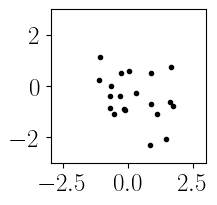

In [2]:
N    = 20
dim  = 2
data = np.random.randn(N,dim)

# define voronoi tesselation
vor = Voronoi(data)

# plot data points
plt.figure(figsize=(2,2))
plt.plot(data[:,0],data[:,1],'.k')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define models

In [3]:
from score_models import VE, VP, GMM_score
from scipy import integrate

class GMM_score_reversetime(GMM_score):
    '''
        GMM score function which corresponds to the stationary point of the denoising score-matching loss function
    '''
    def __init__(self, train_data, process):
        self.train_data = train_data
        self.process    = process

    def scaling_factors(self, s):
        if self.process == 'VE':
            mean_factor   = 1.0
            weight_factor = 1.0
        elif self.process == 'VP':
            mean_factor   = torch.sqrt(1 - torch.exp(-2.*s))
            weight_factor = 1./torch.sqrt(1 - torch.exp(-2.*s))
        else:
            raise ValueError('Process is not recognized')
        return mean_factor, weight_factor

    def pdf_weights(self, y, s):
        # determine scaling factors
        mean_s, weight_s = self.scaling_factors(s)
        batch_s = torch.ones(y.shape[0], device=y.device) * s
        # evaluate Gaussian densities
        logpdf_x_yi = torch.zeros((y.shape[0],self.train_data.shape[0]))
        for i in range(self.train_data.shape[0]):
            logpdf_x_yi[:,i] = self.log_normal_pdf(y, mean_s * self.train_data[i,:], torch.exp(-2.*batch_s))
        # compute weights
        return weight_s * torch.softmax(logpdf_x_yi, axis=1)

    def forward(self, y, s):
        # compute weights
        weights = self.pdf_weights(y, s)
        # compute weighted average
        evals = torch.mm(weights, self.train_data) 
        evals[torch.isnan(evals)] = 0.0
        return -1.*(y - evals)

    def ODEsampler(self, init_y, S0, Sf, err_tol=1e-5):
        def ode_func(s, sample):        
            """The ODE function for use by the ODE solver."""
            sample = torch.tensor(sample, device=init_y.device, dtype=torch.float32).reshape(init_y.shape)
            with torch.no_grad():    
                rhs = self.forward(sample, torch.tensor([s]).float())
            return rhs.detach().numpy().reshape((-1,)).astype(np.float64)
        # Run the RK solver
        res = integrate.solve_ivp(ode_func, (S0, Sf), init_y.reshape(-1).cpu().numpy(), \
                                  rtol=err_tol, atol=err_tol, method='RK45', dense_output=True)  
        y_shape = [init_y.shape[0], init_y.shape[1], len(res.t)]
        y = torch.tensor(res.y, device=init_y.device, dtype=torch.float32).reshape(y_shape)
        return (res.t, y)

folder = 'figures/TransformedTime'
# create folder to save results if it doesn't exixt
import os
if not os.path.exists(folder):
    os.makedirs(folder)

## Generate trajectories with VP

Time interval: (tensor([0.1262]), tensor([20.1262]))


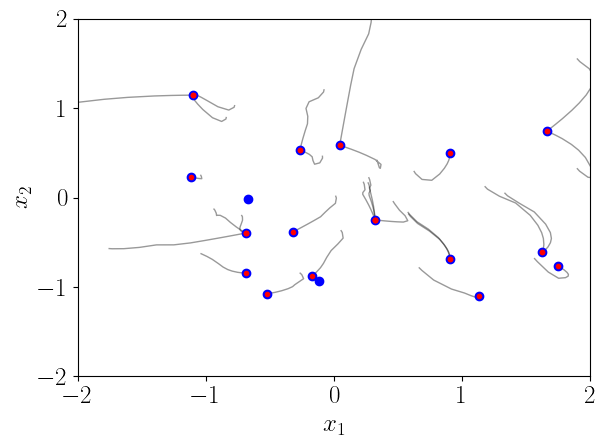

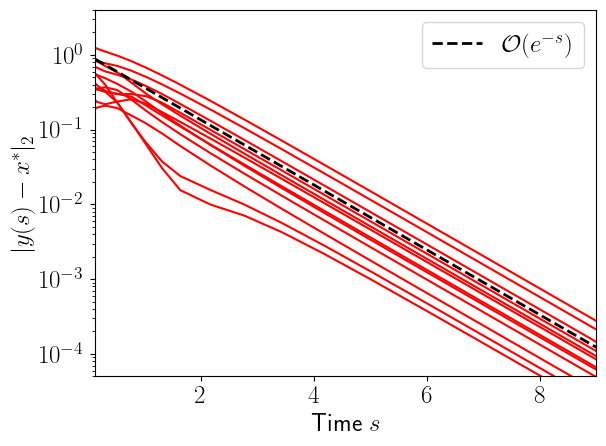

In [19]:
# define process
process = VP()

# define GMM
gmm = GMM_score_reversetime(torch.tensor(data).float(), process='VP')

# define initial and final time points
T = torch.tensor([1.0])
s0 = -np.log(process.marginal_prob_std(T))
sf = s0 + 20
print('Time interval: ('+str(s0)+', '+str(sf)+')')

# define latent samples
batch_size = 30
latents = torch.randn(batch_size, dim).to(device)

# generate new samples
GMM_s, GMM_x = gmm.ODEsampler(latents, S0=s0, Sf=sf)

plt.figure()
for i in range(batch_size):
    plt.plot(GMM_x[i,0,:], GMM_x[i,1,:], '-k', alpha=0.4, linewidth=1)
plt.plot(data[:,0],data[:,1], '.b', markersize=12)
plt.plot(GMM_x[:,0,-1], GMM_x[:,1,-1], '.r',markersize=6)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
plt.savefig(folder + '/VPsolutions.pdf')

plt.figure()
for i in range(12):
    # compute distance to final point
    res_i = GMM_x[i,:,:]
    dist = torch.sqrt(torch.sum((res_i - res_i[:,-1][:,np.newaxis])**2, axis=0))
    plt.semilogy(GMM_s, dist, '-r')
plt.semilogy(GMM_s, np.exp(-1*GMM_s), '--k', linewidth=2, label='$\mathcal{O}(e^{-s})$')
plt.xlabel('Time $s$')
plt.ylabel('$|y(s) - x^*|_2$')
plt.xlim(s0,9)
plt.ylim(5e-5,4)
plt.legend()
plt.tight_layout()
plt.savefig(folder + '/VPconvergence.pdf')


## Generate solutions with VE

Time interval: (tensor([-1.5340]), tensor([8.4660]))


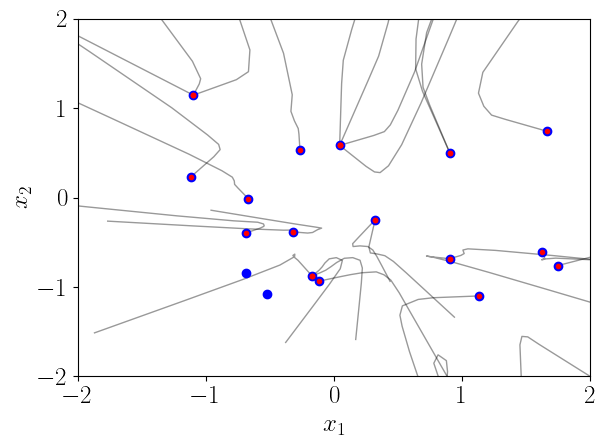

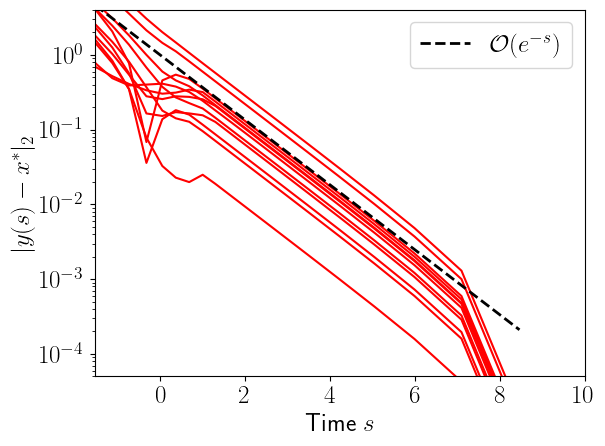

In [11]:
# define process
process = VE()

# define GMM
gmm = GMM_score_reversetime(torch.tensor(data).float(), process='VE')

# define initial and final time points
T = torch.tensor([1.0])
s0 = -np.log(process.marginal_prob_std(T))
sf = s0 + 10
print('Time interval: ('+str(s0)+', '+str(sf)+')')

# define latent samples
batch_size = 30
latents = process.marginal_prob_std(T) * torch.randn(batch_size, dim).to(device)

# generate new samples
GMM_s, GMM_x = gmm.ODEsampler(latents, S0=s0, Sf=sf)

plt.figure()
for i in range(batch_size):
    plt.plot(GMM_x[i,0,:], GMM_x[i,1,:], '-k', alpha=0.4, linewidth=1)
plt.plot(data[:,0],data[:,1], '.b', markersize=12)
plt.plot(GMM_x[:,0,-1], GMM_x[:,1,-1], '.r',markersize=6)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
plt.savefig(folder + '/VEsolutions.pdf')

plt.figure()
for i in range(12):
    # compute distance to final point
    res_i = GMM_x[i,:,:]
    dist = torch.sqrt(torch.sum((res_i - res_i[:,-1][:,np.newaxis])**2, axis=0))
    plt.semilogy(GMM_s, dist, '-r')
plt.semilogy(GMM_s, np.exp(-1*GMM_s), '--k', linewidth=2, label='$\mathcal{O}(e^{-s})$')
plt.xlabel('Time $s$')
plt.ylabel('$|y(s) - x^*|_2$')
plt.xlim(s0,10)
plt.ylim(5e-5,4)
plt.legend()
plt.tight_layout()
plt.savefig(folder + '/VEconvergence.pdf')
